In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mfpml.problems.multifidelity_functions import *
from scipy.stats import pearsonr
from mfpml.design_of_experiment import MFSobolSequence

/tmp/ipykernel_9057/4103423295.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# calculate the correlation of each function
problem_sets = [
    "mf_Bohachevsky",
    "mf_Booth",
    "mf_Borehole",
    "mf_CurrinExp",
    "mf_Hartman3",
    "mf_Hartman6",
    "mf_Himmelblau",
    "mf_Park91A",
    "mf_Park91B",
    "mf_Sixhump",
]
# create an array to store the correlation
correlation_array = pd.DataFrame(
    np.zeros((len(problem_sets), 3)), columns=["function", "correlation", "dimension"]
)
for name in problem_sets:
    func = eval(name)()
    # get samplers
    sampler = MFSobolSequence(design_space=func.design_space, nested=True)
    # sample the function
    samples = sampler.get_samples(num_lf_samples=1000, num_hf_samples=1000)
    responses = func(samples)
    # calculate the correlation
    r2 = pearsonr(responses["hf"].flatten(), responses["lf"].flatten())
    # save the correlation
    correlation_array.loc[problem_sets.index(name), "function"] = name
    correlation_array.loc[problem_sets.index(name), "correlation"] = r2.correlation
    correlation_array.loc[problem_sets.index(name), "dimension"] = func.num_dim

    print("=====================================")
    print("Function: ", name)
    print("Correlation: ", r2.correlation)
    print("Dimension: ", func.num_dim)
    print("=====================================")
# print(correlation_array)
correlation_array

Function:  mf_Bohachevsky
Correlation:  0.8571687854925277
Dimension:  2
Function:  mf_Booth
Correlation:  0.9253300067261739
Dimension:  2
Function:  mf_Borehole
Correlation:  0.9999999999969837
Dimension:  8
Function:  mf_CurrinExp
Correlation:  0.997332184215833
Dimension:  2
Function:  mf_Hartman3
Correlation:  -0.19467082385543386
Dimension:  3
Function:  mf_Hartman6
Correlation:  0.7116051806337151
Dimension:  6
Function:  mf_Himmelblau
Correlation:  0.7615295443218492
Dimension:  2
Function:  mf_Park91A
Correlation:  0.9937046390490585
Dimension:  4
Function:  mf_Park91B
Correlation:  0.9999999999999999
Dimension:  4
Function:  mf_Sixhump
Correlation:  0.8333712630380281
Dimension:  2


/tmp/ipykernel_9057/1551772897.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'mf_Bohachevsky' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correlation_array.loc[problem_sets.index(name), "function"] = name


,function,correlation,dimension
0,mf_Bohachevsky,0.857169,2.0
1,mf_Booth,0.925330,2.0
2,mf_Borehole,1.000000,8.0
3,mf_CurrinExp,0.997332,2.0
4,mf_Hartman3,-0.194671,3.0
5,mf_Hartman6,0.711605,6.0
6,mf_Himmelblau,0.761530,2.0
7,mf_Park91A,0.993705,4.0
8,mf_Park91B,1.000000,4.0
9,mf_Sixhump,0.833371,2.0


## read results from the file

In this notebook, we will do ablation study about MF-RBF-Kriging model.


In [8]:
# read results for mf-rbf-kriging
mf_rbf_kriging_input = pd.read_csv(
    "../mf_rbf_kriging/exp_mf_rbf_input.csv", index_col=0
)
mf_rbf_kriging_output = pd.read_csv(
    "../mf_rbf_kriging/exp_mf_rbf_output.csv", index_col=0
)
# merge input and output
mf_rbf_kriging_results = pd.merge(
    mf_rbf_kriging_input, mf_rbf_kriging_output, left_index=True, right_index=True
)
# remove the results of mf_Himmelblau
mf_rbf_kriging_results = mf_rbf_kriging_results[
    mf_rbf_kriging_results["problem"] != "mf_Himmelblau"
]
# make normalized_mae and normalized_rmse to be absolute value
mf_rbf_kriging_results["normalized_mae"] = mf_rbf_kriging_results[
    "normalized_mae"
].abs()
mf_rbf_kriging_results["normalized_rmse"] = mf_rbf_kriging_results[
    "normalized_rmse"
].abs()


# load kriging results
kriging_input = pd.read_csv("../kriging/exp_kriging_input.csv", index_col=0)
kriging_output = pd.read_csv("../kriging/exp_kriging_output.csv", index_col=0)
# merge input and output
kriging_results = pd.merge(
    kriging_input, kriging_output, left_index=True, right_index=True
)
# make normalized_mae and normalized_rmse to be absolute value
kriging_results["normalized_mae"] = kriging_results["normalized_mae"].abs()
kriging_results["normalized_rmse"] = kriging_results["normalized_rmse"].abs()
# remove results of "Forrestor_1a"
kriging_results = kriging_results[kriging_results["problem"] != "Forrester_1a"]

In [9]:
mf_rbf_kriging_results.problem.unique()

array(['mf_Bohachevsky', 'mf_Booth', 'mf_Borehole', 'mf_CurrinExp',
       'mf_Hartman3', 'mf_Hartman6', 'mf_Park91A', 'mf_Park91B',
       'mf_Sixhump'], dtype=object)

In [10]:
# create a new dataframe of  mf_rbf_kriging_results with num_lf from 25 to 100 with step 10
# and num_hf from 2 to 20 with step 4
mf_rbf_kriging_results_new = pd.DataFrame()
for num_lf in range(30, 101, 10):
    num_lf = int(num_lf)
    for num_hf in [2, 6, 10, 14, 18, 20]:
        num_hf = int(num_hf)
        mf_rbf_kriging_results_new = pd.concat(
            [
                mf_rbf_kriging_results_new,
                mf_rbf_kriging_results[
                    (mf_rbf_kriging_results["num_lf"] == num_lf)
                    & (mf_rbf_kriging_results["num_hf"] == num_hf)
                ],
            ]
        )

In [11]:
mf_rbf_kriging_results_new

,method,num_hf,num_lf,problem,seed,progress,normalized_mae,normalized_rmse,r2,cpu_time
10,mf_rbf,2,30,mf_Bohachevsky,1,finished,1.732169,0.430927,0.556335,0.901940
210,mf_rbf,2,30,mf_Bohachevsky,2,finished,1.682519,0.594109,0.191411,0.981565
410,mf_rbf,2,30,mf_Bohachevsky,3,finished,1.380934,0.529264,0.335107,0.488912
610,mf_rbf,2,30,mf_Bohachevsky,4,finished,2.144343,0.399026,0.638353,0.884206
810,mf_rbf,2,30,mf_Bohachevsky,5,finished,1.481680,0.399594,0.633295,0.599845
...,...,...,...,...,...,...,...,...,...,...
9159,mf_rbf,20,100,mf_Sixhump,1,finished,0.116945,0.027285,0.999621,2.502380
9359,mf_rbf,20,100,mf_Sixhump,2,finished,0.045223,0.010401,0.999943,3.327883
9559,mf_rbf,20,100,mf_Sixhump,3,finished,0.073813,0.013990,0.999894,3.424673
9759,mf_rbf,20,100,mf_Sixhump,4,finished,0.063193,0.006794,0.999976,2.926462


/tmp/ipykernel_9057/1438124524.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations_mean = pivot_table["mean"].applymap(
/tmp/ipykernel_9057/1438124524.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_table["std"].applymap("{:.2f}".format).astype(str).values
/tmp/ipykernel_9057/1438124524.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_table_cpu_time["mean"].applymap("{:.2f}".format).astype(str).values
/tmp/ipykernel_9057/1438124524.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_table_cpu_time["std"].applymap("{:.2f}".format).astype(str).values


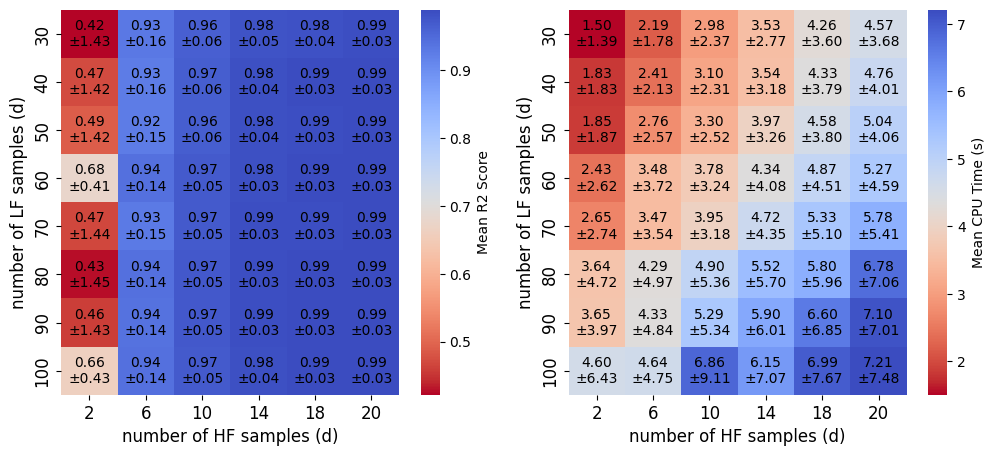

In [16]:
# Create a pivot table for num_lf, num_hf, mean, and std of r2
pivot_table = mf_rbf_kriging_results_new.pivot_table(
    values="r2", index="num_lf", columns="num_hf", aggfunc=["mean", "std"]
)

# Create a custom annotation array with both mean and std values
annotations_mean = pivot_table["mean"].applymap("{:.2f}".format).astype(str).values
annotations_std = "±" + pivot_table["std"].applymap("{:.2f}".format).astype(str).values

# Combine annotations
annotations_combined = [
    f"{m}\n{s}" for m, s in zip(annotations_mean.flatten(), annotations_std.flatten())
]
annotations_combined = np.array(annotations_combined).reshape(annotations_mean.shape)


# Create a pivot table for num_lf, num_hf, mean, and std of cpu_time
pivot_table_cpu_time = mf_rbf_kriging_results_new.pivot_table(
    values="cpu_time", index="num_lf", columns="num_hf", aggfunc=["mean", "std"]
)

# Create a custom annotation array with both mean and std values for cpu_time
annotations_mean_cpu_time = (
    pivot_table_cpu_time["mean"].applymap("{:.2f}".format).astype(str).values
)
annotations_std_cpu_time = (
    "±" + pivot_table_cpu_time["std"].applymap("{:.2f}".format).astype(str).values
)

# Combine annotations for cpu_time
annotations_combined_cpu_time = [
    f"{m}\n{s}"
    for m, s in zip(
        annotations_mean_cpu_time.flatten(), annotations_std_cpu_time.flatten()
    )
]
annotations_combined_cpu_time = np.array(annotations_combined_cpu_time).reshape(
    annotations_mean_cpu_time.shape
)

# Create a combined heatmap for cpu_time
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    pivot_table["mean"],
    annot=annotations_combined,
    fmt="",
    cmap="coolwarm_r",
    cbar_kws={"label": "Mean R2 Score"},
    annot_kws={"color": "black"},
    ax=ax[0],
)
ax[0].set_xlabel("number of HF samples (d)", fontsize=12)
ax[0].set_ylabel("number of LF samples (d)", fontsize=12)
ax[0].set_xticklabels([2, 6, 10, 14, 18, 20], fontsize=12)
ax[0].set_yticklabels([30, 40, 50, 60, 70, 80, 90, 100], fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(
    pivot_table_cpu_time["mean"],
    annot=annotations_combined_cpu_time,
    fmt="",
    cmap="coolwarm_r",
    annot_kws={"color": "black"},
    cbar_kws={"label": "Mean CPU Time (s)"},
    ax=ax[1],
)
plt.xlabel("number of HF samples (d)", fontsize=12)
plt.ylabel("number of LF samples (d)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("mf_rbf_kriging_sample_influence.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_rbf_kriging_sample_influence.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_rbf_kriging_sample_influence.svg", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
# create a pandas data-frame with num_lf=100
mf_rbf_kriging_results_new_100 = mf_rbf_kriging_results[
    mf_rbf_kriging_results["num_lf"] == 100
]
mf_rbf_kriging_results_new_100

,method,num_hf,num_lf,problem,seed,progress,normalized_mae,normalized_rmse,r2,cpu_time
150,mf_rbf,2,100,mf_Bohachevsky,1,finished,1.244776,0.413288,0.591911,1.685736
151,mf_rbf,4,100,mf_Bohachevsky,1,finished,1.033538,0.272001,0.823237,0.773493
152,mf_rbf,6,100,mf_Bohachevsky,1,finished,0.227152,0.059479,0.991548,1.402390
153,mf_rbf,8,100,mf_Bohachevsky,1,finished,0.165427,0.047133,0.994692,2.409916
154,mf_rbf,10,100,mf_Bohachevsky,1,finished,0.063972,0.020610,0.998985,1.548617
...,...,...,...,...,...,...,...,...,...,...
9955,mf_rbf,12,100,mf_Sixhump,5,finished,0.557443,0.088972,0.995780,2.667922
9956,mf_rbf,14,100,mf_Sixhump,5,finished,0.034937,0.005962,0.999981,2.094870
9957,mf_rbf,16,100,mf_Sixhump,5,finished,0.064468,0.007356,0.999971,3.244398
9958,mf_rbf,18,100,mf_Sixhump,5,finished,0.087888,0.014693,0.999885,2.839946


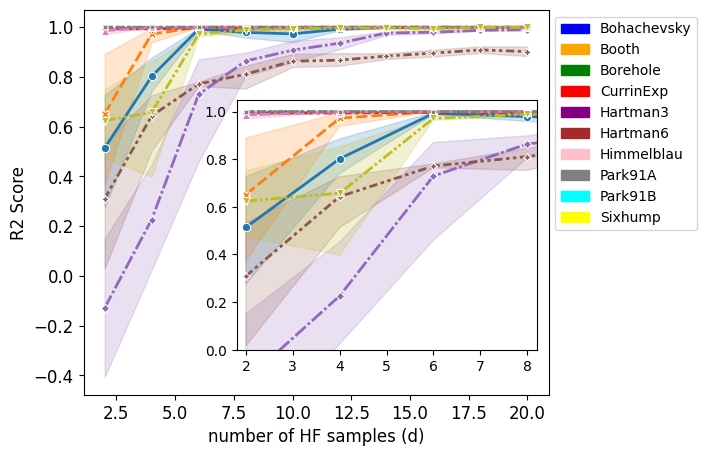

In [14]:
# plot the influence of num_hf on r2
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(
    data=mf_rbf_kriging_results_new_100,
    x="num_hf",
    y="r2",
    hue="problem",
    style="problem",
    linewidth=2,
    markers=True,
    ax=ax,
)
plt.xlabel("number of HF samples (d)", fontsize=12)
plt.ylabel("R2 Score", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
legend_elements = [
    Patch(color="blue", label="Bohachevsky"),
    Patch(color="orange", label="Booth"),
    Patch(color="green", label="Borehole"),
    Patch(color="red", label="CurrinExp"),
    Patch(color="purple", label="Hartman3"),
    Patch(color="brown", label="Hartman6"),
    Patch(color="pink", label="Himmelblau"),
    Patch(color="gray", label="Park91A"),
    Patch(color="cyan", label="Park91B"),
    Patch(color="yellow", label="Sixhump"),
]
ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))
# Add a subplot on top
# Adjust the [left, bottom, width, height] values as needed
ax_inset = plt.axes([0.38, 0.2, 0.5, 0.5])
sns.lineplot(
    data=mf_rbf_kriging_results_new_100,
    x="num_hf",
    y="r2",
    hue="problem",
    style="problem",
    linewidth=2,
    markers=True,
    ax=ax_inset,
)
ax_inset.set_xlim([1.8, 8.2])
ax_inset.set_ylim([0, 1.05])
ax_inset.legend().set_visible(False)
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")


plt.show()

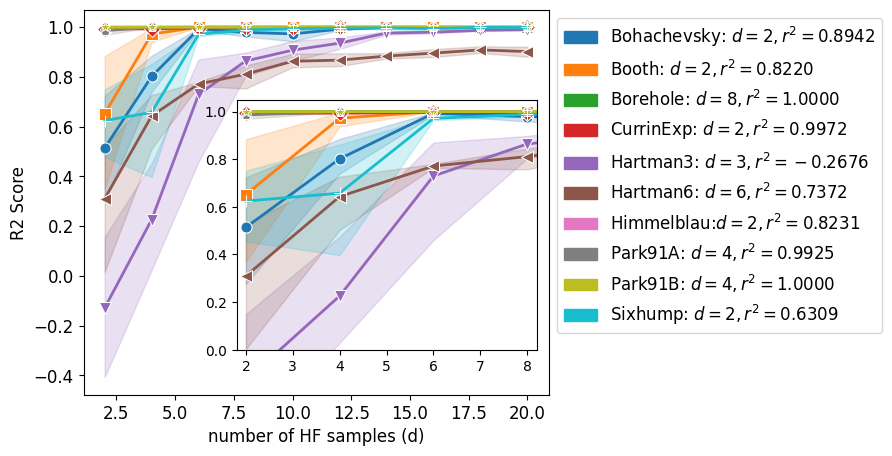

In [15]:
# Define colors corresponding to each problem
colors = {
    "mf_Bohachevsky": "#1f77b4",
    "mf_Booth": "#ff7f0e",
    "mf_Borehole": "#2ca02c",
    "mf_CurrinExp": "#d62728",
    "mf_Hartman3": "#9467bd",
    "mf_Hartman6": "#8c564b",
    "mf_Himmelblau": "#e377c2",
    "mf_Park91A": "#7f7f7f",
    "mf_Park91B": "#bcbd22",
    "mf_Sixhump": "#17becf",
}
markers = {
    "mf_Bohachevsky": "o",
    "mf_Booth": "s",
    "mf_Borehole": "^",
    "mf_CurrinExp": "D",
    "mf_Hartman3": "v",
    "mf_Hartman6": "<",
    "mf_Himmelblau": ">",
    "mf_Park91A": "p",
    "mf_Park91B": "*",
    "mf_Sixhump": "+",
}

# plot the influence of num_hf on r2
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for problem, color in colors.items():
    subset = mf_rbf_kriging_results_new_100[
        mf_rbf_kriging_results_new_100["problem"] == problem
    ]
    sns.lineplot(
        x=subset["num_hf"],
        y=subset["r2"],
        color=color,
        label=problem,
        linewidth=2,
        marker=markers[problem],
        markersize=8,  # Adjust the marker size as needed
        ax=ax,
    )
plt.xlabel("number of HF samples (d)", fontsize=12)
plt.ylabel("R2 Score", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a subplot on top
# Adjust the [left, bottom, width, height] values as needed
ax_inset = plt.axes([0.38, 0.2, 0.5, 0.5])
for problem, color in colors.items():
    subset = mf_rbf_kriging_results_new_100[
        mf_rbf_kriging_results_new_100["problem"] == problem
    ]
    sns.lineplot(
        x=subset["num_hf"],
        y=subset["r2"],
        color=color,
        label=problem,
        linewidth=2,
        marker=markers[problem],
        markersize=8,  # Adjust the marker size as needed
        ax=ax_inset,
    )
ax_inset.set_xlim([1.8, 8.2])
ax_inset.set_ylim([0, 1.05])
ax_inset.legend().set_visible(False)
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")

# Set the custom legend
legend_elements = [
    Patch(color="#1f77b4", label=r"Bohachevsky: $d=2, r^2=0.8942$"),
    Patch(color="#ff7f0e", label=r"Booth: $d=2, r^2=0.8220$"),
    Patch(color="#2ca02c", label=r"Borehole: $d=8, r^2=1.0000$"),
    Patch(color="#d62728", label=r"CurrinExp: $d=2, r^2=0.9972$"),
    Patch(color="#9467bd", label=r"Hartman3: $d=3, r^2=-0.2676$"),
    Patch(color="#8c564b", label=r"Hartman6: $d=6, r^2=0.7372$"),
    Patch(color="#e377c2", label=r"Himmelblau:$ d=2, r^2=0.8231$"),
    Patch(color="#7f7f7f", label=r"Park91A: $d=4, r^2=0.9925$"),
    Patch(color="#bcbd22", label=r"Park91B: $d=4, r^2=1.0000$"),
    Patch(color="#17becf", label=r"Sixhump: $d=2, r^2=0.6309$"),
]
ax.legend(handles=legend_elements, loc="upper left",
          bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig("mf_rbf_kriging_correlation_influence.png",
            dpi=300, bbox_inches="tight")
plt.savefig("mf_rbf_kriging_correlation_influence.pdf",
            dpi=300, bbox_inches="tight")
plt.savefig("mf_rbf_kriging_correlation_influence.svg",
            dpi=300, bbox_inches="tight")

plt.show()

In [104]:
# select mf_Hartman3 function
mf_rbf_kriging_results_hartman3 = mf_rbf_kriging_results[
    mf_rbf_kriging_results["problem"] == "mf_Hartman6"
]
kriging_results_hartman3 = kriging_results[kriging_results["problem"] == "mf_Hartman6"]

kriging_results_hartman3[kriging_results_hartman3["num_sample"] == 20]["r2"].mean()

0.8818276065071469

In [96]:
# find out the case with 100d lf samples and 10d hf samples
aa = mf_rbf_kriging_results_hartman3[
    (mf_rbf_kriging_results_hartman3["num_lf"] == 100)
    & (mf_rbf_kriging_results_hartman3["num_hf"] == 20)
]
aa["r2"].mean()

0.8955030789890508

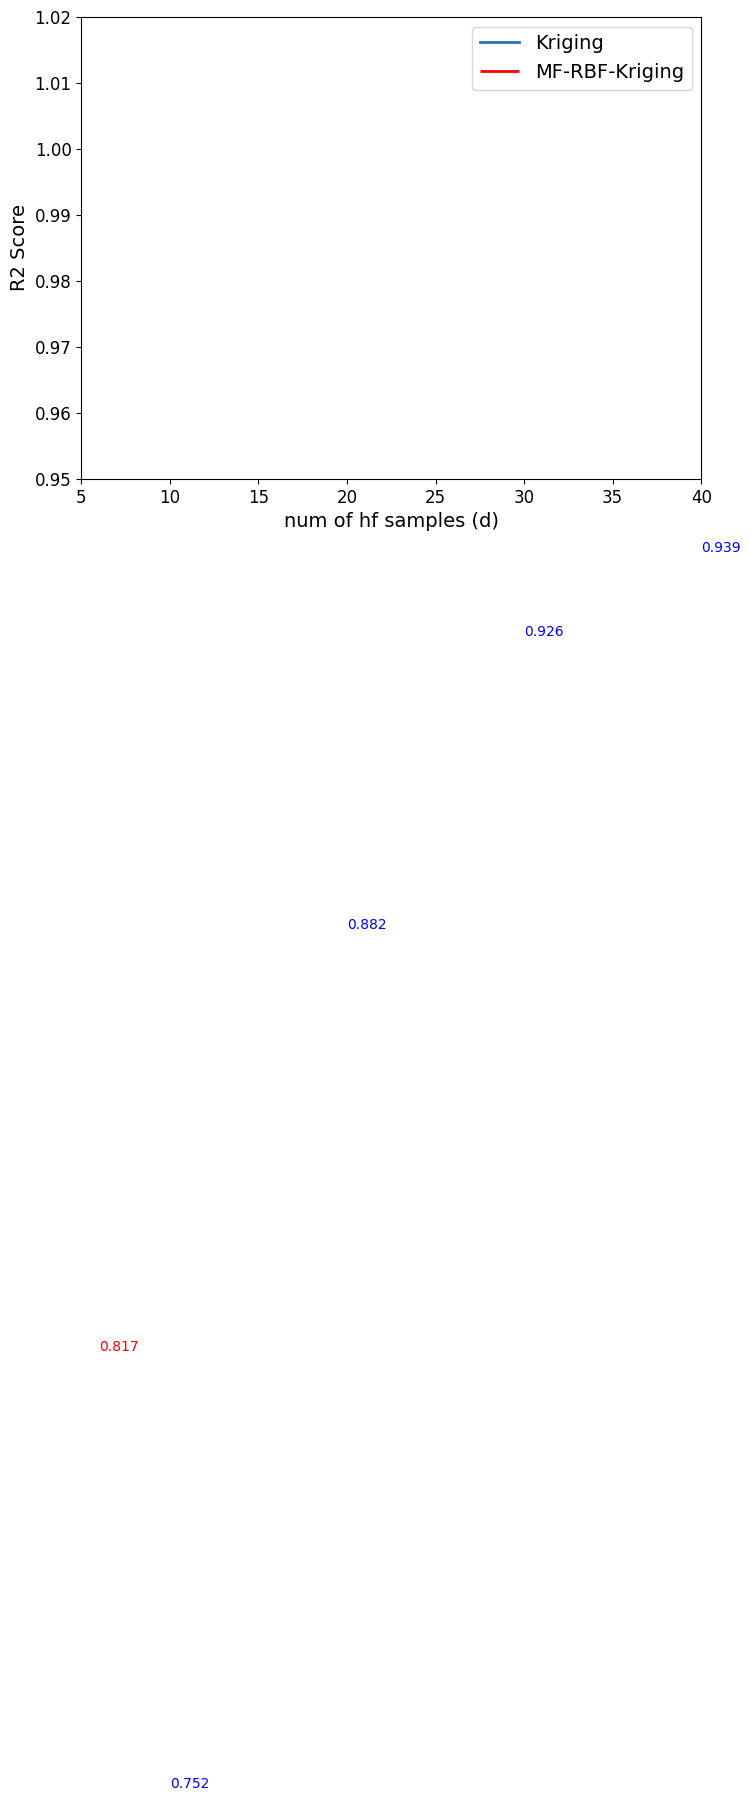

In [92]:
# plot accuracy of kriging with different number of samples
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    x="num_sample",
    y="r2",
    data=kriging_results_hartman3,
    label="Kriging",
    linewidth=2,
)

# plot results of mf-rbf-kriging
plt.hlines(
    y=aa["r2"].mean(),
    xmin=6,
    xmax=40,
    label="MF-RBF-Kriging",
    colors="red",
    linewidth=2,
)
plt.text(6, aa["r2"].mean() + 0.001, f"{aa['r2'].mean():.3f}", color="red")
# Calculate the average "r2" value for each num_sample
average_r2_per_sample = kriging_results_hartman3.groupby("num_sample")[
    "r2"].mean()
# Annotate each point with the average "r2" value
for i, (num_sample, average_r2) in enumerate(average_r2_per_sample.items()):
    if (i + 1) % 5 == 0:  # Show every 2nd iteration
        plt.text(num_sample, average_r2, f"{average_r2:.3f}", color="blue")


plt.fill_between(
    x=[6, 40],
    y1=aa["r2"].mean() - 1.95 * aa["r2"].std(),
    y2=aa["r2"].mean() + 1.95 * aa["r2"].std(),
    color="red",
    alpha=0.2,
)
plt.xlabel("num of hf samples (d)", fontsize=14)
plt.ylabel("R2 Score", fontsize=14)
ax.set_xlim(5, 40)
ax.set_ylim(0.95, 1.02)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

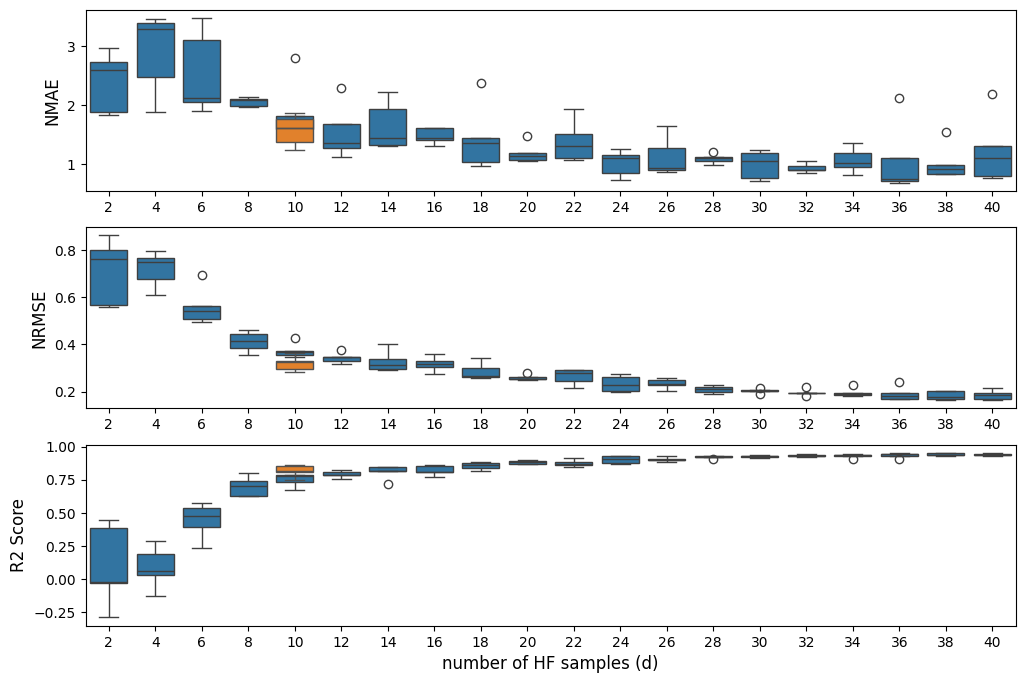

In [93]:
# same plots for normalized_mae and normalized_rmse and r2
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
sns.boxplot(
    x="num_sample",
    y="normalized_mae",
    data=kriging_results_hartman3,
    ax=ax[0],
)
# # plot results of mf-rbf-kriging
sns.boxplot(
    x="num_hf",
    y="normalized_mae",
    data=aa,
    ax=ax[0],
)
# plot settings
ax[0].set_ylabel("NMAE", fontsize=12)
ax[0].set_xlabel("")
# plot normalized_rmse
sns.boxplot(
    x="num_sample",
    y="normalized_rmse",
    data=kriging_results_hartman3,
    ax=ax[1],
)
# # plot results of mf-rbf-kriging
sns.boxplot(
    x="num_hf",
    y="normalized_rmse",
    data=aa,
    ax=ax[1],
)
# plot settings
ax[1].set_ylabel("NRMSE", fontsize=12)
ax[1].set_xlabel("")

# plot r2
sns.boxplot(
    x="num_sample",
    y="r2",
    data=kriging_results_hartman3,
    ax=ax[2],
)
# # plot results of mf-rbf-kriging
sns.boxplot(
    x="num_hf",
    y="r2",
    data=aa,
    ax=ax[2],
)
# plot settings
ax[2].set_ylabel("R2 Score", fontsize=12)
ax[2].set_xlabel("number of HF samples (d)", fontsize=12)


plt.savefig("mf_rbf_kriging_six_hump_accuracy.png",
            dpi=300, bbox_inches="tight")
plt.savefig("mf_rbf_kriging_six_hump_accuracy.pdf",
            dpi=300, bbox_inches="tight")
plt.savefig("mf_rbf_kriging_six_hump_accuracy.svg",
            dpi=300, bbox_inches="tight")
plt.show()